# 🌌 Photo-Z Challenge: Blind Test Set Prediction  🚀

 Here, we will load our configuration directly, preprocess the completely blind test set, run inference using our trained model, and finally visualize the predictions! 

In [1]:
# Import essential libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ML_models import PhotoZNet, RandomForestPhotoZ

# Set up dark background for all plots
plt.style.use('dark_background')

/var/folders/6r/hl4s187n5b37619mh7d94nb40000gn/T/ipykernel_85557/1429835628.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## ⚙️ 1. Configuration Setup

To keep this notebook self-contained, we define the configuration and model architectures directly here. Make sure this configuration matches exactly the one used to train the model.

In [29]:
# Pipeline configuration dictionary embedded from config.yaml
cfg = {
    "experiment": {
        "group_name": "Forest-Z",
        "save_dir": "models/"
    },
    "data": {
        "train_path": "data/training_set.h5", # Adjusted path assuming notebook is in photoz_challenge/
        "val_path": "data/validation_set.h5",
        "batch_size": 1000,
        "target_col": "Z",
        "inputs": {
            "FilterJPAS": [
                'J0378', 'J0390', 'J0400', 'J0410', 'J0420', 'J0430', 'J0440', 'J0450',
                'J0460', 'J0470', 'J0480', 'J0490', 'J0500', 'J0510', 'J0520', 'J0530',
                'J0540', 'J0550', 'J0560', 'J0570', 'J0580', 'J0590', 'J0600', 'J0610',
                'J0620', 'J0630', 'J0640', 'J0650', 'J0660', 'J0670', 'J0680', 'J0690',
                'J0700', 'J0710', 'J0720', 'J0730', 'J0740', 'J0750', 'J0760', 'J0770',
                'J0780', 'J0790', 'J0800', 'J0810', 'J0820', 'J0830', 'J0840', 'J0850',
                'J0860', 'J0870', 'J0880', 'J0890', 'J0900', 'J0910'
            ],
            "MAGNITUDES": [
                'MAG_NUV','MAG_FUV','MAG_G','MAG_R','MAG_i','MAG_Z',"MAG_J_2MASS",
                "MAG_H_2MASS","MAG_Ks_2MASS",'MAG_W1','MAG_W2','MAG_W3','MAG_W4', 'iSDSS'
            ]
        },
        "selected_features": ["FilterJPAS", "MAGNITUDES"],
        "features_to_normalize": ["MAGNITUDES"]
    },
    "model": {
        "type": "random_forest", # Options: "neural_net", "random_forest"
        "hidden_layers": [512, 512],
        "dropout_rates": [0.2, 0.2],
        "output_size": 1,
        "n_estimators": 500,
        "max_depth": 100
    },
    "training": {
        "epochs": 20,
        "learning_rate": 0.001,
        "loss_type": "deltaz"
    }
}

## 🧹 2. Data Preprocessing & Helpers

Before our model can make predictions, we need to prepare the data! We will define functions to calculate scaling statistics (Median Absolute Deviation) and normalize our features.  This ensures our model receives data in the exact format it expects. Please make sure that all the preprocsing of the data that you made during training is also applied during inference. 

In [30]:
# Helper function to calculate Median Absolute Deviation for robust scaling
def get_mad(series):
    median = series.median()
    return (series - median).abs().median()

# Prepares features for inference without requiring target columns (Z or TYPE)
def preprocess_blind_data(df, config, train_stats):
    selected_cols = []
    for group in config['data']['selected_features']:
        selected_cols.extend(config['data']['inputs'][group])
    
    X = df[selected_cols].copy()
    
    # Fill missing values with 0.0
    X = X.fillna(0.0)

    cols_to_norm = []
    for group in config['data']['features_to_normalize']:
        if group in config['data']['selected_features']:
             cols_to_norm.extend(config['data']['inputs'][group])
    
    # Apply normalization using the provided training statistics
    X[cols_to_norm] = (X[cols_to_norm] - train_stats['medians']) / train_stats['mads']
    
    return X.values, len(selected_cols)

## 🤖 3. Inference and Prediction Generation

 We will load the training dataset just to grab the normalization statistics, and then we will load the blind test set. After that, we fire up our trained model, make our predictions, and save everything into a CSV file ready for submission! 🏆

In [31]:
# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dynamic paths using config to avoid hardcoded absolute paths
train_path = cfg['data']['train_path']
data_dir = os.path.dirname(train_path)
blind_test_path = os.path.join(data_dir, 'blind_test_set.h5')

print("Loading training data to calculate normalization statistics...")
df_train = pd.read_hdf(train_path, key='data')

# Calculate normalization statistics from training data
cols_to_norm = []
for group in cfg['data']['features_to_normalize']:
    if group in cfg['data']['selected_features']:
         cols_to_norm.extend(cfg['data']['inputs'][group])
         
X_train_norm_base = df_train[cols_to_norm].fillna(0.0)
medians = X_train_norm_base.median()
mads = X_train_norm_base.apply(get_mad).replace(0, 1.0)
train_stats = {'medians': medians, 'mads': mads}

# Free up memory before loading the blind test set
del df_train, X_train_norm_base

print(f"Loading blind test data from {blind_test_path}...")
df_blind = pd.read_hdf(blind_test_path, key='data')

print("Pre-processing blind test data...")
X_blind, input_dim = preprocess_blind_data(df_blind, cfg, train_stats)

# Extract the group name and model type to correctly load the model
group_name = cfg['experiment']['group_name']
model_type = cfg['model'].get('type', 'neural_net')

print(f"Initializing {model_type} model...")

if model_type == 'neural_net':
    model = PhotoZNet(
        input_size=input_dim,
        hidden_layers=cfg['model']['hidden_layers'],
        dropout_rates=cfg['model']['dropout_rates']
    ).to(device)
    
    model_path = os.path.join(cfg['experiment']['save_dir'], f"{group_name}.pth")
    print(f"Loading weights from {model_path}...")
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()

    print("Running inference...")
    with torch.no_grad():
        inputs_tensor = torch.FloatTensor(X_blind).to(device)
        preds = model(inputs_tensor).cpu().numpy().flatten()
        # Neural networks do not output standard deviation in this setup
        preds_std = np.full(preds.shape, np.nan)
        
elif model_type == 'random_forest':
    model = RandomForestPhotoZ()
    model_path = os.path.join(cfg['experiment']['save_dir'], f"{group_name}_rf.joblib")
    print(f"Loading weights from {model_path}...")
    model.load(model_path)
    
    print("Running inference...")
    preds, preds_std = model.predict(X_blind)

print("Preparing predictions for submission...")
output_df = pd.DataFrame({
    'TARGETID': df_blind['TARGETID'],
    'Z_PRED': preds,
    'Z_PRED_STD': preds_std
})

# Save the results to the dynamic data folder
output_filename = f"predictions_{group_name}.csv"
output_path = os.path.join(data_dir, output_filename)

output_df.to_csv(output_path, index=False)
print(f"Predictions successfully saved to: {output_path}")

Using device: cpu
Loading training data to calculate normalization statistics...
Loading blind test data from data/blind_test_set.h5...
Pre-processing blind test data...
Initializing random_forest model...
Loading weights from models/Forest-Z_rf.joblib...
Running inference...
Preparing predictions for submission...
Predictions successfully saved to: data/predictions_Forest-Z.csv


## 📊 4. Visualizing the Predictions

Let's take a look at what our model actually predicted! 👀 We will plot the distribution of our predicted redshifts and explore how the predictions relate to the `iSDSS` magnitude. If our model calculated predictive uncertainties, we will visualize those too! 

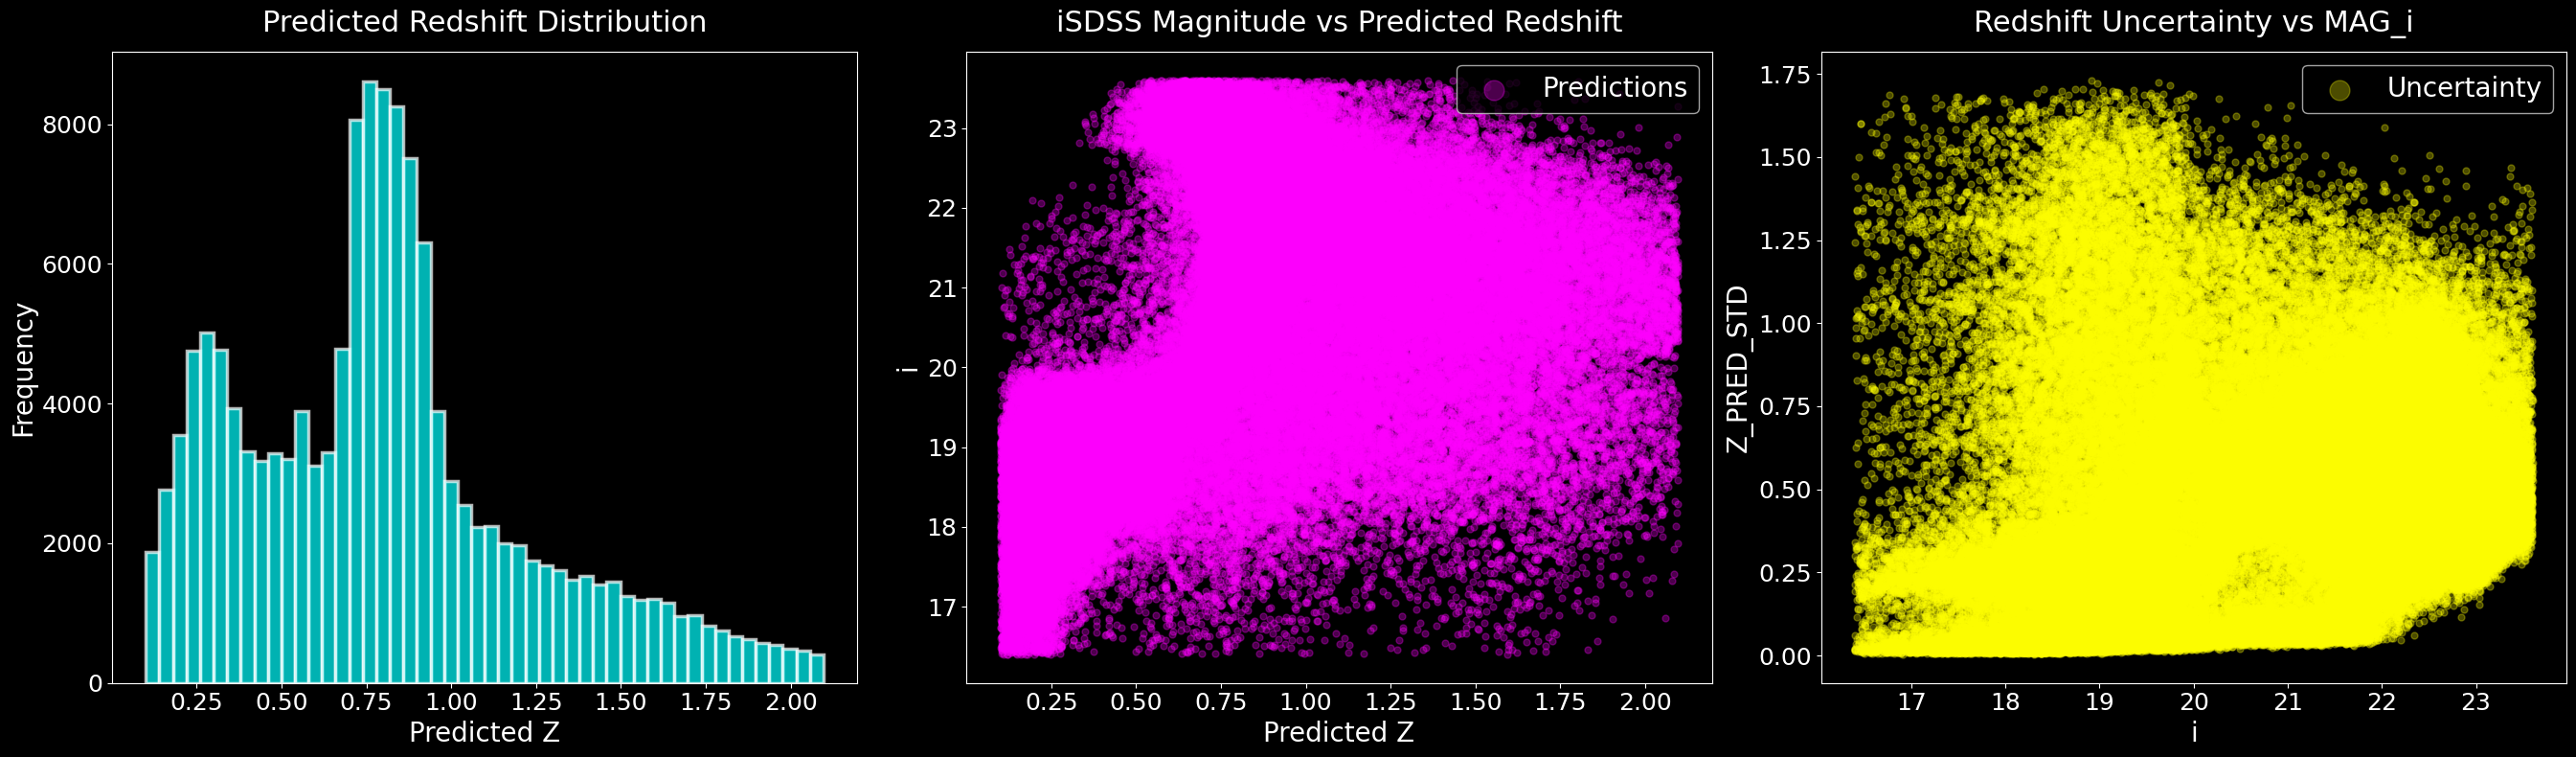

In [32]:
# Extract necessary columns for plotting
mag_i = df_blind['MAG_i'].values
z_pred = output_df['Z_PRED'].values
z_err = output_df['Z_PRED_STD'].values

# Calculate percentiles to filter out extreme outliers and create a smart axis
p1_z, p99_z = np.nanpercentile(z_pred, [1, 99])
p1_mag, p99_mag = np.nanpercentile(mag_i, [1, 99])

# Ensure valid ranges after removing outliers
z_mask = (z_pred >= p1_z) & (z_pred <= p99_z)
mag_mask = (mag_i >= p1_mag) & (mag_i <= p99_mag)
valid_mask = z_mask & mag_mask

z_pred_clean = z_pred[valid_mask]
mag_i_clean = mag_i[valid_mask]
z_err_clean = z_err[valid_mask]

# Create figure depending on whether we have standard deviations (uncertainties)
has_errors = not np.isnan(z_err_clean).all()
n_cols = 3 if has_errors else 2

fig, axes = plt.subplots(1, n_cols, figsize=(9 * n_cols, 8))

# 1. Distribution of predicted redshifts
axes[0].hist(z_pred_clean, bins=50, color='cyan', alpha=0.7, edgecolor='white', linewidth=2.5)
axes[0].set_title('Predicted Redshift Distribution', fontsize=22, pad=15)
axes[0].set_xlabel('Predicted Z', fontsize=20)
axes[0].set_ylabel('Frequency', fontsize=20)
axes[0].tick_params(axis='both', labelsize=18)
axes[0].grid(False)

# 2. iSDSS Magnitude vs Predicted Redshift
axes[1].scatter(z_pred_clean, mag_i_clean, alpha=0.3, color='magenta', s=25, label='Predictions')
axes[1].set_title('iSDSS Magnitude vs Predicted Redshift', fontsize=22, pad=15)
axes[1].set_xlabel('Predicted Z', fontsize=20)
axes[1].set_ylabel('i', fontsize=20)
axes[1].tick_params(axis='both', labelsize=18)
axes[1].grid(False)
axes[1].legend(fontsize=20, markerscale=3)

# 3. Prediction Uncertainty vs iSDSS Magnitude (If available)
if has_errors:
    axes[2].scatter(mag_i_clean, z_err_clean, alpha=0.3, color='yellow', s=25, label='Uncertainty')
    axes[2].set_title('Redshift Uncertainty vs MAG_i', fontsize=22, pad=15)
    axes[2].set_xlabel('i', fontsize=20)
    axes[2].set_ylabel('Z_PRED_STD', fontsize=20)
    axes[2].tick_params(axis='both', labelsize=18)
    axes[2].grid(False)
    axes[2].legend(fontsize=20, markerscale=3)

plt.tight_layout()
plt.show()